In [1]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())
import pickle
from testsuite.utilities import Pareto_split
import numpy as np
from testsuite.analysis import load_all, plot_all_pareto_2d, PLOT_STYLE, plot_measure
import matplotlib.pyplot as plt

In [2]:
dir_path = os.getcwd()
result_dirs = sorted(os.listdir("./log_data/"))
result_dirs

['test_function_Saf_init10_MultiSurrogate_ei',
 'test_function_Saf_init10_MultiSurrogate_mean',
 'test_function_SmsEgo_init10_MultiSurrogate_ei',
 'test_function_SmsEgo_init10_MultiSurrogate_mean']

In [3]:
saf_ei_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[0]))
saf_mu_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[1]))
sms_ei_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[2]))
sms_mu_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[3]))

In [4]:
print(len(saf_ei_results["y"]))
print(len(saf_mu_results["y"]))
print(len(sms_ei_results["y"]))
print(len(sms_mu_results["y"]))

7
7
3
5


In [5]:
names = ["saf_ei",
         "saf_mu",
         "sms_ei",
         "sms_mu"]

In [6]:
import wfg
N= 500

n_obj = 6                                   # Number of objectives
kfactor = 1
lfactor = 2

k = kfactor*(n_obj-1)   # position related params
l = lfactor*2           # distance related params
n_dim = k+l

func = wfg.WFG6

x_limits = np.zeros((2, n_dim))
x_limits[1] = np.array(range(1,n_dim+1))*2


args = [k, n_obj] # number of objectives as argument

# y = np.zeros((N, n_obj))
# for n in range(N):
#     z = wfg.random_soln(k, l, func.__name__)
#     y[n,:] = func(z, k, n_obj)/(np.array(range(1, n_obj+1))*2)

In [7]:
from pymoo.factory import get_performance_indicator

In [8]:
def scatter_nsphere(n_points, n_dims, weighting=None):
    """scatter n_points onto unit n-spere with n_dims dimensions"""
    if weighting is None:
        weighting = np.ones(n_dims)
    else:
        weighting = np.array(weighting)
    points = np.random.randn(n_points,n_dims)*weighting
    d = (points**2).sum(axis=1)**0.5
    norm_points = (points.T/d.T).T
    return np.abs(norm_points)

In [9]:
y = scatter_nsphere(500, n_obj, np.arange(1,n_obj+1)*2)

In [10]:
def extract_performance(z, indicator):
    ANS  = []
    for i in range(9, len(z)):
        p = Pareto_split(z[:i])[0]
        ans = indicator.calc(p)
        ANS.append(ans)

    return ANS

In [11]:
import lhsmdu
lhs_x =np.array(lhsmdu.sample(numDimensions=n_dim, numSamples=100)).T*x_limits[1]
lhs_y = np.array([func(z, k, n_obj) for z in lhs_x])/(np.array(range(1, n_obj+1))*2)

In [12]:
ref = lhs_y.max(axis=0)
ref

array([0.93122461, 0.77213365, 0.94827185, 1.07280702, 1.07702405,
       1.0651146 ])

In [13]:
igdp = get_performance_indicator("igd+", y)
hv = get_performance_indicator("hv", ref_point=ref)

In [14]:
lhslhs_results = {"y": lhs_y,
                 "x": lhs_x}

lhslhs_results["n_initial"] = saf_ei_results['n_initial'][0]
lhslhs_results["hypervolume"] = hv.calc(lhslhs_results["y"])
lhslhs_results["igd"] = igdp.calc(lhslhs_results["y"])

print(lhslhs_results['hypervolume'])
print(lhslhs_results['igd'])
print(lhslhs_results['n_initial'])

ref_hv = hv.calc(np.zeros_like(ref))
print(ref_hv)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False

0.183381090173708
0.26893557208956126
10
0.8391181718550403


In [15]:
saf_ei_results['igd'] = [extract_performance(saf_ei_results["y"][i], igdp) for i in range(len(saf_ei_results["y"]))]
saf_mu_results['igd'] = [extract_performance(saf_mu_results["y"][i], igdp) for i in range(len(saf_mu_results["y"]))]
sms_ei_results['igd'] = [extract_performance(sms_ei_results["y"][i], igdp) for i in range(len(sms_ei_results["y"]))]
sms_mu_results['igd'] = [extract_performance(sms_mu_results["y"][i], igdp) for i in range(len(sms_mu_results["y"]))]

In [16]:
saf_ei_results['hypervolume'] = [extract_performance(saf_ei_results["y"][i], hv) for i in range(len(saf_ei_results["y"]))]
saf_mu_results['hypervolume'] = [extract_performance(saf_mu_results["y"][i], hv) for i in range(len(saf_mu_results["y"]))]
sms_ei_results['hypervolume'] = [extract_performance(sms_ei_results["y"][i], hv) for i in range(len(sms_ei_results["y"]))]
sms_mu_results['hypervolume'] = [extract_performance(sms_mu_results["y"][i], hv) for i in range(len(sms_mu_results["y"]))]

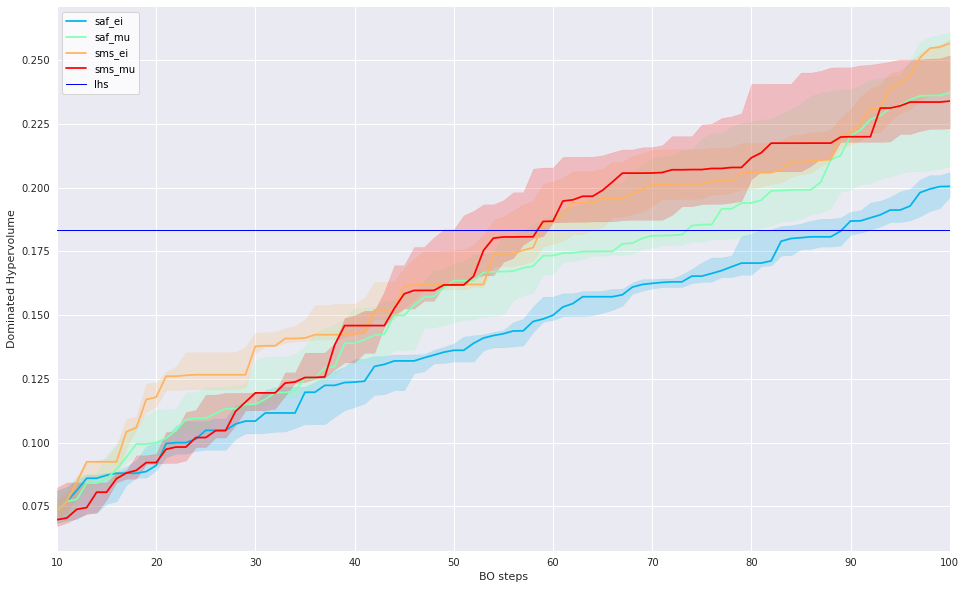

In [17]:
with plt.style.context(PLOT_STYLE["plot_style"]):
    fig_hv = plt.figure(figsize=[16, 10])
    ax_hv = fig_hv.gca()

cmap = PLOT_STYLE['plot_cmap']
colors = cmap(np.linspace(0, 1, len(result_dirs)+1))

plot_measure(saf_ei_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="saf_ei", color=colors[1])
plot_measure(saf_mu_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="saf_mu", color=colors[2])
plot_measure(sms_ei_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="sms_ei", color=colors[3])
plot_measure(sms_mu_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="sms_mu", color=colors[4])
ax_hv.axhline(lhslhs_results["hypervolume"], linewidth=1, color="b", label="lhs")
# ax_hv.plot(range(10,101), q_result["hypervolume"], linewidth=1, color="r", label="q")
ax_hv.set_xlim([10, 100])
ax_hv.set_xlabel("BO steps")
ax_hv.set_ylabel("Dominated Hypervolume")
ax_hv.legend()

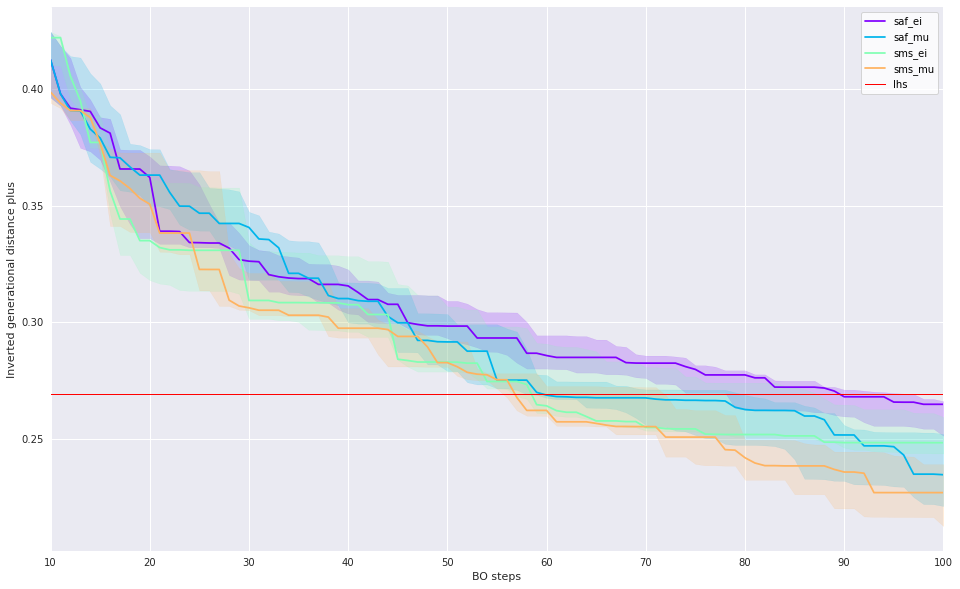

In [19]:
with plt.style.context(PLOT_STYLE["plot_style"]):
    fig_hv = plt.figure(figsize=[16, 10])
    ax_hv = fig_hv.gca()

cmap = PLOT_STYLE['plot_cmap']
colors = cmap(np.linspace(0, 1, len(result_dirs)+1))

plot_measure(saf_ei_results, measure="igd", axis=ax_hv, plot_individuals=False, label="saf_ei", color=colors[0])
plot_measure(saf_mu_results, measure="igd", axis=ax_hv, plot_individuals=False, label="saf_mu", color=colors[1])
plot_measure(sms_ei_results, measure="igd", axis=ax_hv, plot_individuals=False, label="sms_ei", color=colors[2])
plot_measure(sms_mu_results, measure="igd", axis=ax_hv, plot_individuals=False, label="sms_mu", color=colors[3])
ax_hv.axhline(lhslhs_results["igd"], linewidth=1, color="r", label="lhs")
# ax_hv.axhline(lhslhs_results["igd"][0], xmin=10, xmax=100, c=colors[7], label="lhs")

ax_hv.set_xlim([10, 100])
ax_hv.set_xlabel("BO steps")
ax_hv.set_ylabel("Inverted generational distance plus")
ax_hv.legend()

In [18]:
[result["errors"] for result in results]

[[[], [], []], [[], [], []], [[], [], []], [[], [], []], [[], [], []]]

In [19]:
try:
    for result, name in zip(results, names):
        pickle.dump(result, open("./pkl_data/"+name+".pkl", "wb"))
except FileNotFoundError:
    os.mkdir("./pkl_data")
    for result, name in zip(results, names):
        pickle.dump(result, open("./pkl_data/"+name+".pkl", "wb"))

In [19]:
sms_ei_results["y"][0].max(axis=0)

array([1.06477995, 0.81151601, 0.8917829 , 1.00316199, 1.05041701])